In [25]:
import pandas as pd
import numpy as np
from numpy import vstack, mean, std
import h5py
import torch
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics 
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import Tensor, nn
from torch.nn import Linear, Sigmoid, Module, BCELoss 
import torch.nn.functional as F
from torch.optim import SGD
from preprocessing import preprocess
from get_symbol import get_symbol
from prediction_pipeline import *
import random

# Load and prepare data

In [3]:
def load_data(expression_path, libraries, gr_truth_path): 
    norm = get_expression_data(expression_path)
    binary_matrix = get_binary_matrix(norm.index, libraries)
    gr_truth = get_gr_truth(norm.columns, gr_truth_path)
    list_inputs = prepare_data(norm, binary_matrix)
    return list_inputs, gr_truth

def get_expression_data(expression_path): 
    f = pd.read_csv(expression_path)
    f.index = f.iloc[:, 0] # Make ENSG genes as row indexing 
    f = f.iloc[:, 1:] # Remove first index column 
    # Normalize data 
    norm = preprocess(f)
    # Convert Ensembl number index to gene symbol
    norm = get_symbol(norm)
    return norm 

def get_binary_matrix(gene_expr, libraries):
    function_to_genes = {}
    set_genes = set()
    for lib in libraries: 
        f2g, genes = gene_set_dictionaries(lib)
        function_to_genes.update(f2g)
        set_genes = set_genes | set(genes)
    common_genes = list(set_genes & set(gene_expr))
    binary_matrix = gs_binary_matrix(function_to_genes, set_genes).loc[common_genes]
    return binary_matrix

def get_gr_truth(list_samples, gr_truth_path):
    gr_truth = pd.read_csv(gr_truth_path, sep='\t')
    gr_truth = gr_truth.iloc[10, 1:]
    idx = [ "_".join(i.split("_")[:2]) for i in gr_truth.index ]
    gr_truth.index = idx
    gr_truth = pd.DataFrame(gr_truth).loc[list_samples]
    test = [ 1.0 if res[-3:] == 'POS' else 0.0 for res in gr_truth.iloc[:, 0] ]
    gr_truth.iloc[:, 0] = test
    gr_truth.columns = ["Truth"]
    return gr_truth

def prepare_data(norm, binary_matrix):
    # load the dataset
    list_inputs = []
    common_genes = set(binary_matrix.index) & set(norm.index)
    bm = binary_matrix.loc[common_genes]
    bm_tens = torch.tensor(bm.T.values)
    for sample in norm.columns: 
        item = torch.mul(bm_tens, torch.tensor(norm.loc[common_genes, sample].values))
        list_inputs.append(np.array(item).astype(np.float32))
    return list_inputs 

In [4]:
# load the data 
expression_path = 'GSE156063_swab_gene_counts.csv.gz'
libraries = ['GO_Biological_Process_2018', 'GO_Molecular_Function_2018', 'GO_Cellular_Component_2018']
gr_truth_path = "GSE156063_series_matrix.txt"
list_inputs, gr_truth = load_data(expression_path, libraries, gr_truth_path) 
X_train, X_test, y_train, y_test = train_test_split(list_inputs, gr_truth, test_size=0.33, random_state=42) 

# Neural network

In [33]:
class Net(nn.Module):
    def __init__(self, shape):
        super(Net, self).__init__()
        self.fc1 = Linear(shape[1], 1)
        self.fc2 = Linear(shape[0], 1)
        self.sigmoid = nn.Sigmoid()

    # x represents our data
    def forward(self, x):
        y = torch.from_numpy(x)
        y = self.fc1(y)
        y = self.fc2(y.T) 
        y = self.sigmoid(y)
        return y

# train model 
def train_model(X_train, y_train, model, lr=1e-4, momentum=0.6): 
    # define optimization 
    criterion = BCELoss() 
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum) 
    # enumerate epochs 
    for epoch in range(100):
        # ennumerate mini batches 
        for i in range(len(X_train)): 
            inputs = X_train[i]
            targets = torch.from_numpy(y_train[i].astype(np.float32))
            # clear the gradients 
            optimizer.zero_grad() 
            # compute the model output 
            yhat = model(inputs)[0]
            # calculate loss 
            loss = criterion(yhat, targets)
            # credit assignment 
            loss.backward()
            # update model weights 
            optimizer.step()

def cross_validation(X, y, model='StratifiedKFold'): 
    model_dict = {'StratifiedKFold': StratifiedKFold(n_splits=10), 'LOOCV': LeaveOneOut()}
    cv = model_dict[model]
    list_auc = []
    ns_probs = [0 for _ in range(len(X))]
    ns_auc = roc_auc_score(y, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    for train_idx, test_idx in cv.split(X, y): 
        X_train, X_test = [X[i] for i in train_idx], [X[i] for i in test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model = Net(X_train[0].shape)
        train_model(X_train, np.array(y_train), model)
        lr_auc, lr_fpr, lr_tpr = evaluate_model(X_test, y_test, model, cv=True)
        list_auc.append(lr_auc) 
        plt.plot(lr_fpr, lr_tpr, marker='.')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plot text
    auc_text = "Avg AUC: {:.2f}".format(np.mean(list_auc))
    plt.annotate(auc_text, xy=(1,0), xycoords='axes fraction', textcoords='offset points', ha='right', va='bottom')
    # show the plot
    plt.show()
    return list_auc
        
            
def evaluate_model(X_test, y_test, model, cv=False): 
    predictions, actuals = [], [] 
    for i in range(len(X_test)): 
        inputs = X_test[i]
        targets = torch.from_numpy(y_test[i].astype(np.float32))
        # evaluate model on test set 
        yhat = model(inputs)[0]
        # retrieve numpy array 
        yhat = yhat.detach().numpy() 
        # store 
        predictions.append(yhat)
        actuals.append(targets) 
    predictions, actuals = vstack(predictions), vstack(actuals)
    
    # calculate AUC 
    ns_probs = [0 for _ in range(len(X_test))]
    ns_auc = roc_auc_score(actuals, ns_probs)
    lr_auc = roc_auc_score(actuals, predictions) 
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions)
    
    if cv: return lr_auc, lr_fpr, lr_tpr 
    
    # summarize scores
    print('No skill: ROC AUC=%.3f' % (ns_auc))
    print('Fully-connected layer: ROC AUC=%.3f' % (lr_auc))
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Fully-connected layer')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    

def best_lr(X_train, X_test, y_train, y_test): 
    best = 0
    for lr in [1e-5, 1e-4, 1e-3, 1e-2]: 
        for momentum in range(1, 10):
            my_nn = Net(X_train[0].shape)
            train_model(X_train, np.array(y_train), my_nn, lr=lr, momentum=momentum/10)
            lr_auc = evaluate_model(X_test, np.array(y_test), my_nn)
            if lr_auc > best: 
                best = lr_auc
                print(lr_auc)
                print("lr={}".format(lr))
                print("momentum={}".format(momentum))

## Train-test split

No skill: ROC AUC=0.500
Fully-connected layer: ROC AUC=0.904


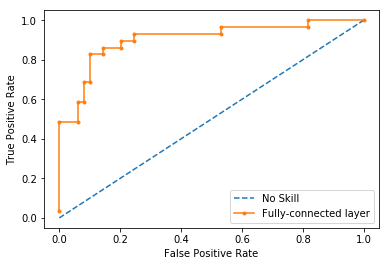

In [28]:
my_nn = Net(X_train[0].shape)
train_model(X_train, np.array(y_train), my_nn) 
evaluate_model(X_test, np.array(y_test), my_nn) # 1e-4, 0.6

## Stratified k-fold cross-validation

/opt/apps/rhel7/Python-GPU-3.6.5/lib/python3.6/site-packages/matplotlib/text.py:2108: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


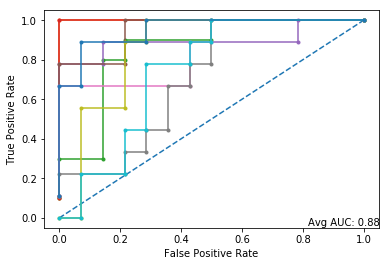

NameError: name 'list_aucs' is not defined

In [34]:
list_aucs = cross_validation(list_inputs, np.array(gr_truth), model='StratifiedKFold')